# SVM Model Training 
### by Salvina 
enjoy.. ;)

## Importing Relevant Libraries
Just the relevant libraries hehe

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score

## Loading Dataset 

Loading the dataset using the pandas library and then using head to show the first 5 columns

In [10]:
# Load the data
data = pd.read_csv('epl-training_vina.csv')
pd.set_option('display.max_columns',None)
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,19/08/2000,Charlton,Man City,4,0,H,2,0,H,Rob Harris,17,8,14,4,6,6,13,12,1,2,0,0
1,19/08/2000,Chelsea,West Ham,4,2,H,1,0,H,Graham Barber,17,12,10,5,7,7,19,14,1,2,0,0
2,19/08/2000,Coventry,Middlesbrough,1,3,A,1,1,D,Barry Knight,6,16,3,9,8,4,15,21,5,3,1,0
3,19/08/2000,Derby,Southampton,2,2,D,1,2,A,Andy D'Urso,6,13,4,6,5,8,11,13,1,1,0,0
4,19/08/2000,Leeds,Everton,2,0,H,2,0,H,Dermot Gallagher,17,12,8,6,6,4,21,20,1,3,0,0


## Encoding features 
Assigning the features a numerical value so that it is easier to identify by the model 

In [11]:
# Encode team names
team_encoder = LabelEncoder()
le_team = LabelEncoder()
data['HomeTeamID'] = team_encoder.fit_transform(data['HomeTeam'])
data['AwayTeamID'] = team_encoder.transform(data['AwayTeam'])
unique_home = pd.concat([data['HomeTeam']]).unique()
unique_away = pd.concat([data['AwayTeam']]).unique()
le_team.fit(unique_home)
le_team.fit(unique_away)

# Encode target variable
result_mapping = {'H': 1, 'D': 0, 'A': -1}
data['FTR'] = data['FTR'].map(result_mapping)

In [12]:
# Initialize team stats
team_stats = {team: {'wins': 0, 'draws': 0, 'losses': 0, 'goals_for': 0, 'goals_against': 0, 'matches': 0} 
              for team in team_encoder.classes_}

# Calculate historical performance metrics
def update_team_stats(row):
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    ftr = row['FTR']  # Full-time result
    home_goals = row['FTHG']
    away_goals = row['FTAG']

    # Update home team stats
    team_stats[home_team]['goals_for'] += home_goals
    team_stats[home_team]['goals_against'] += away_goals
    team_stats[home_team]['matches'] += 1
    if ftr == 1:  # Home win
        team_stats[home_team]['wins'] += 1
    elif ftr == 0:  # Draw
        team_stats[home_team]['draws'] += 1
    else:  # Away win
        team_stats[home_team]['losses'] += 1

    # Update away team stats
    team_stats[away_team]['goals_for'] += away_goals
    team_stats[away_team]['goals_against'] += home_goals
    team_stats[away_team]['matches'] += 1
    if ftr == -1:  # Away win
        team_stats[away_team]['wins'] += 1
    elif ftr == 0:  # Draw
        team_stats[away_team]['draws'] += 1
    else:  # Home loss
        team_stats[away_team]['losses'] += 1

# Apply stats updates
for index, row in data.iterrows():
    update_team_stats(row)

In [13]:
# Add derived features to the data
def calculate_team_features(row):
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_stats = team_stats[home_team]
    away_stats = team_stats[away_team]

    # Calculate features
    return pd.Series({
        'HomeWinRate': home_stats['wins'] / home_stats['matches'] if home_stats['matches'] > 0 else 0,
        'AwayWinRate': away_stats['wins'] / away_stats['matches'] if away_stats['matches'] > 0 else 0,
        'HomeGoalDiff': home_stats['goals_for'] - home_stats['goals_against'],
        'AwayGoalDiff': away_stats['goals_for'] - away_stats['goals_against']
    })

# Add features to the dataset
data = data.join(data.apply(calculate_team_features, axis=1))

# Define features and labels
features = ['HomeWinRate', 'AwayWinRate', 'HomeGoalDiff', 'AwayGoalDiff']
X = data[features]
y = data['FTR']

In [14]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
# Predict outcome for a new match (team names only)


def predict_match(home_team, away_team):
    # Derive features for the match
    home_stats = team_stats[home_team]
    away_stats = team_stats[away_team]
    match_features = pd.DataFrame([[
        home_stats['wins'] / home_stats['matches'] if home_stats['matches'] > 0 else 0,
        away_stats['wins'] / away_stats['matches'] if away_stats['matches'] > 0 else 0,
        home_stats['goals_for'] - home_stats['goals_against'],
        away_stats['goals_for'] - away_stats['goals_against']
    ]], columns=features)  # Use the same feature names

    match_features_scaled = scaler.transform(match_features)
    predicted_result = svm_model.predict(match_features_scaled)
    return {1: "Home Win", 0: "Draw", -1: "Away Win"}[predicted_result[0]]
# Test prediction
print("The result would be: ",predict_match('Arsenal', 'Liverpool'))
# Performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


The result would be:  Draw
Accuracy: 0.4561288202431811
Classification Report:
               precision    recall  f1-score   support

          -1       0.52      0.43      0.47       869
           0       0.29      0.55      0.38       761
           1       0.68      0.42      0.52      1413

    accuracy                           0.46      3043
   macro avg       0.50      0.47      0.46      3043
weighted avg       0.54      0.46      0.47      3043



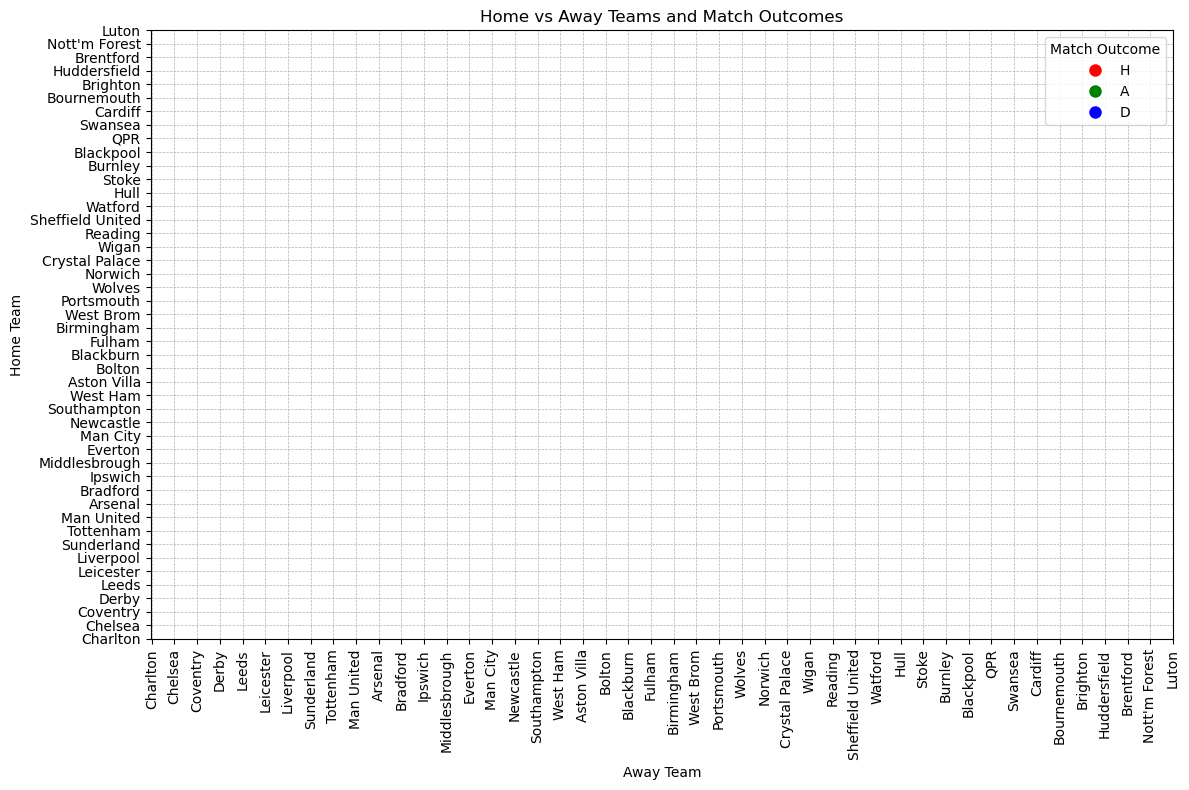

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
team_order = pd.concat([data['HomeTeam'], data['AwayTeam']]).unique()  # Get unique team names
home_team_positions = pd.Categorical(data['HomeTeam'], categories=team_order, ordered=True).codes
away_team_positions = pd.Categorical(data['AwayTeam'], categories=team_order, ordered=True).codes

# Map outcomes to colors
outcome_colors = {'H': 'red', 'A': 'green', 'D': 'blue'}
colors = data['FTR'].map(outcome_colors)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(away_team_positions, home_team_positions, c=colors, alpha=0.7)

# Add gridlines and labels
plt.xticks(ticks=range(len(team_order)), labels=team_order, rotation=90)
plt.yticks(ticks=range(len(team_order)), labels=team_order)
plt.xlabel('Away Team')
plt.ylabel('Home Team')
plt.title('Home vs Away Teams and Match Outcomes')
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

# Add legend
legend_labels = list(outcome_colors.keys())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=outcome_colors[label], markersize=10)
                  for label in legend_labels]
plt.legend(legend_handles, legend_labels, title='Match Outcome')

# Display the plot
plt.tight_layout()
plt.show() 


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
file_path = 'epl-training.csv'
data = pd.read_csv(file_path)

# Encode categorical columns
le_team = LabelEncoder()
data['HomeTeam'] = le_team.fit_transform(data['HomeTeam'])
data['AwayTeam'] = le_team.transform(data['AwayTeam'])

# Define features and target
features = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']  # Add more features if needed
target = 'FTR'  # Full-time result
le_ftr = LabelEncoder()
data['FTR'] = le_ftr.fit_transform(data['FTR'])  # Encode 'FTR'

# Split the data
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train the SVM model
model = SVC(kernel='linear', C=1)
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred,zero_division=0))

# Function to predict outcomes for new matches
def predict_outcome(home_team, away_team, fthg, ftag):
    home_encoded = le_team.transform([home_team])[0]
    away_encoded = le_team.transform([away_team])[0]
    input_data = [[home_encoded, away_encoded, fthg, ftag]]
    prediction = model.predict(input_data)
    return le_ftr.inverse_transform(prediction)[0]

# Example prediction
example_outcome = predict_outcome("Liverpool", "Man City", 2, 1)
print(f"Predicted outcome for Charlton vs Man City: {example_outcome}")


ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values